<a href="https://colab.research.google.com/github/KarimeAylen/vocales.github.io/blob/main/Final_vocales/Copia_de_EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys 
print(sys.version)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 45.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow.keras.optimizers

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
from keras.optimizers import Adam
from tensorflow.python.keras import optimizers         #Optimizador con el que vamos a entrenar el modelo
from tensorflow.python.keras.models import Sequential  #Nos permite hacer redes neuronales secuenciales
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation #
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D  #Capas para hacer las convoluciones
from tensorflow.python.keras import backend as K       #Si hay una sesion de keras, lo cerramos para tener todo limp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
K.clear_session()  #Limpiamos todo


In [ ]:
datos_entrenamiento =__path__=r'/content/drive/MyDrive/IC/Dedos/fotos/Entrenamiento'
datos_validacion =__path__=r'/content/drive/MyDrive/IC/Dedos/fotos/Validacion'

In [ ]:
#Parametros

iteraciones = 100  #Numero de iteraciones para ajustar nuestro modelo
altura, longitud = 200, 200 #Tamaño de las imagenes de entrenamiento
batch_size = 1 #Numero de imagenes que vamos a enviar 1 32
pasos = 300/1  # DEPENDIENDO   #Numero de veces que se va a procesar la informacion en cada iteracion
pasos_validacion = 300/1 #Despues de cada iteracion, validamos lo anterior
filtrosconv1 = 32
filtrosconv2 = 64     #Numero de filtros que vamos a aplicar en cada convolucion
filtrosconv3 = 128

tam_filtro1 = (4,4)
tam_filtro2 = (3,3)   #Tamaños de los filtros 1 y 2
tam_filtro3=(2,2)

tam_pool = (2,2)  #Tamaño del filtro en max pooling
clases = 5 #LETRAS SIN MOV  #Mano abierta y cerrada (5 dedos y 0 dedos)
lr = 0.0005  #ajustes de la red neuronal para acercarse a una solucion optima

In [ ]:
#Pre-Procesamiento de las imagenes
preprocesamiento_entre = ImageDataGenerator(
    rescale= 1./255,   #Pasar los pixeles de 0 a 255 | 0 a 1
    rotation_range=40,
    shear_range = 0.3, #Generar nuestras imagenes inclinadas para un  mejor entrenamiento
    zoom_range = 0.2,  #Genera imagenes con zoom para un mejor entrenamiento
    horizontal_flip=True, #Invierte las imagenes para mejor entrenamiento
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #fill_mode='nearest'
)

preprocesamiento_vali = ImageDataGenerator(
    rescale = 1./255
)

imagen_entreno = preprocesamiento_entre.flow_from_directory(
    datos_entrenamiento,       #Va a tomar las fotos que ya almacenamos
    target_size = (altura, longitud),
    batch_size = batch_size,
    class_mode = 'categorical',  #Clasificacion categorica = por clases
)

imagen_validacion = preprocesamiento_vali.flow_from_directory(
    datos_validacion,
    target_size=(altura,longitud),
    batch_size= batch_size,
    class_mode='categorical'
)

Found 1501 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [ ]:
imgs, labels=next(imagen_entreno)

In [ ]:
labels

array([[0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')     
    plt.tight_layout()
    plt.show()

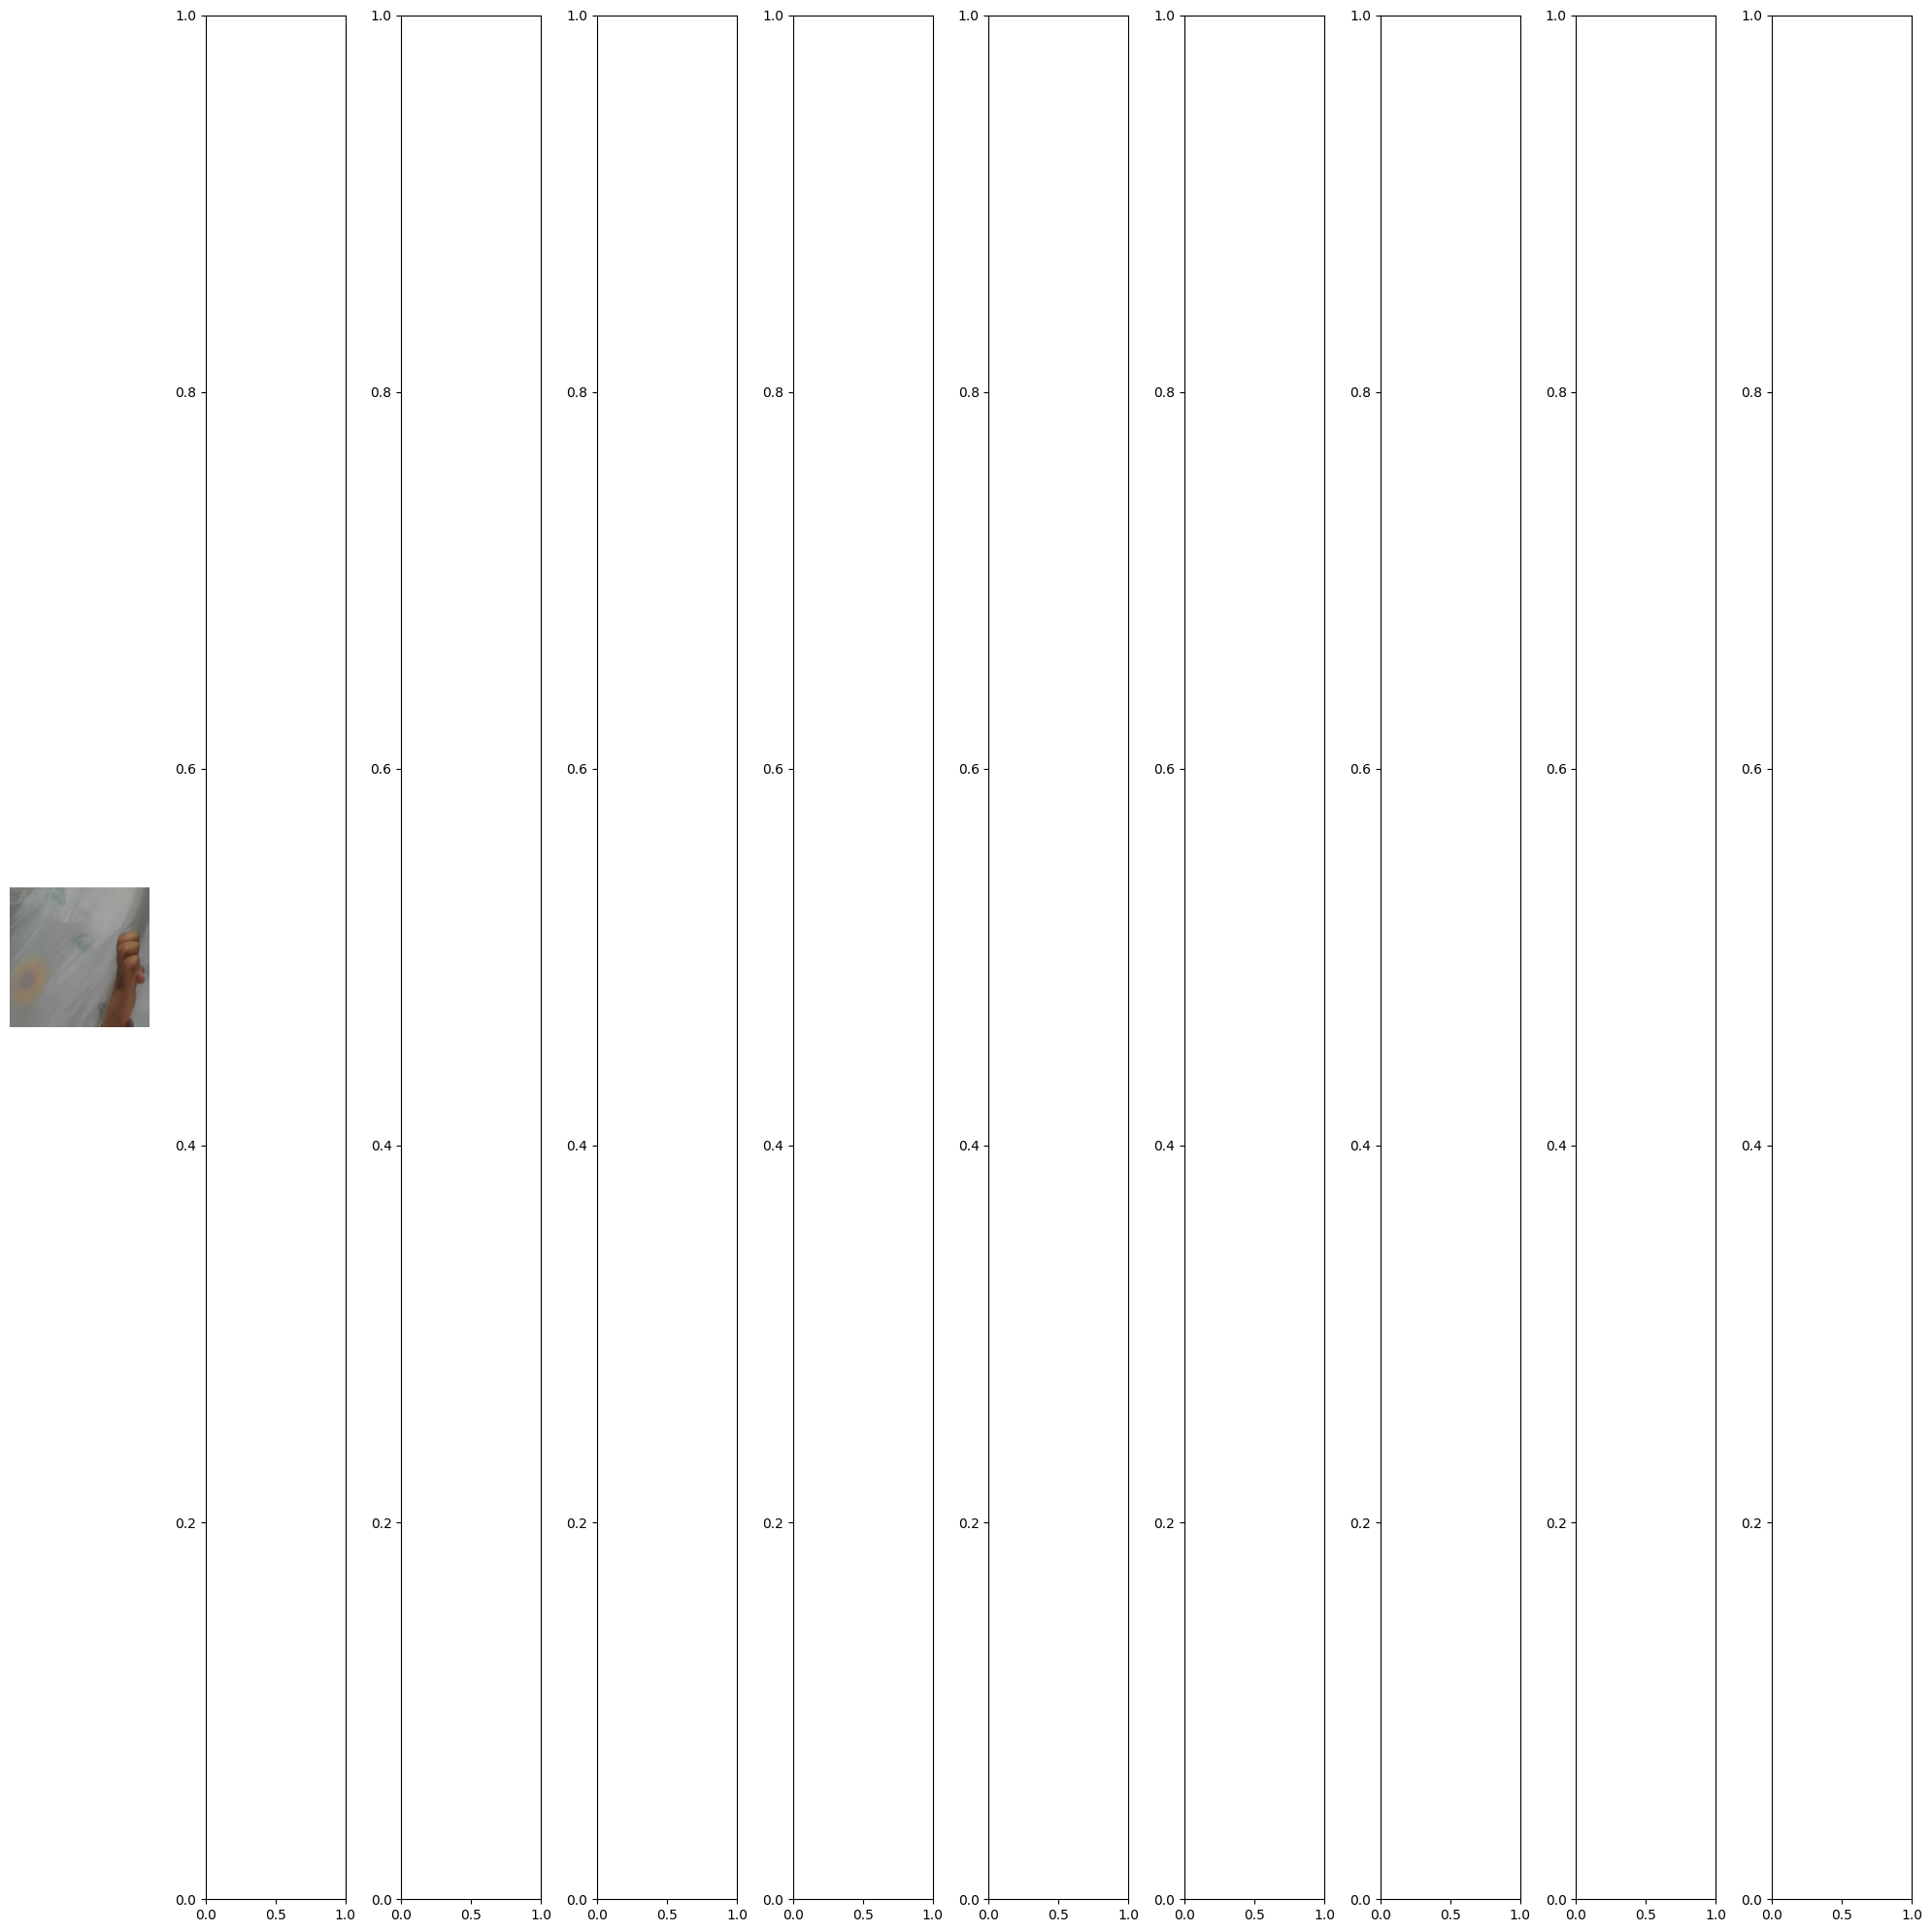

[[0. 1. 0. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
#Creamos la red neuronal convolucional (CNN)
cnn = Sequential()  #Red neuronal secuencial
#Agregamos filtros con el fin de volver nuestra imagen muy profunda pero pequeña
cnn.add(Convolution2D(filtrosconv1, tam_filtro1, padding = 'same', input_shape=(altura,longitud,3), activation = 'relu')) #Agregamos la primera capa   3
         #Es una convolucion y realizamos config
cnn.add(MaxPooling2D(pool_size=tam_pool)) #Despues de la primera capa vamos a tener una capa de max pooling y asignamos el tamaño

cnn.add(Convolution2D(filtrosconv2, tam_filtro2, padding = 'same', activation='relu')) #Agregamos nueva capa
cnn.add(MaxPooling2D(pool_size=tam_pool))
#cnn.add(MaxPooling2D(pool_size=tam_pool))

#nuevo------------
cnn.add(Convolution2D(filtrosconv3, tam_filtro3,padding='same',activation='relu'))
cnn.add(MaxPooling2D(pool_size=tam_pool))
#---

#Ahora vamos a convertir esa imagen profunda a una plana, para tener 1 dimension con toda la info
cnn.add(Flatten())  #Aplanamos la imagen
cnn.add(Dense(640,activation='relu'))  #Asignamos 256-2 neuronas regla de 3     2560
cnn.add(Dropout(0.5)) #Apagamos el 50% de las neuronas en la funcion anterior para no sobreajustar la red
cnn.add(Dense(clases, activation='softmax'))  #Es nuestra ultima capa, es la que nos dice la probabilidad de que 

In [ ]:
history()

In [ ]:
#Agregamos parametros para optimizar el modelo
#Durante el entrenamiento tenga una autoevalucion, que se optimice con Adam, y la metrica sera accuracy
optimizar = tensorflow.keras.optimizers.Adam(learning_rate= lr)
#optimizar = Adam(learning_rate=lr)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=cnn.fit(imagen_entreno, steps_per_epoch=pasos, epochs= iteraciones, validation_data= imagen_validacion, validation_steps=pasos_validacion)

Epoch 1/100
300/300 [==============================] - 146s 456ms/step - loss: 1.7321 - accuracy: 0.2033 - val_loss: 1.6075 - val_accuracy: 0.2367
Epoch 2/100
300/300 [==============================] - 127s 425ms/step - loss: 1.6122 - accuracy: 0.1400 - val_loss: 1.6091 - val_accuracy: 0.2167
Epoch 3/100
300/300 [==============================] - 128s 428ms/step - loss: 1.6110 - accuracy: 0.1933 - val_loss: 1.6115 - val_accuracy: 0.1867
Epoch 4/100
300/300 [==============================] - 128s 427ms/step - loss: 1.6109 - accuracy: 0.1733 - val_loss: 1.6094 - val_accuracy: 0.2233
Epoch 5/100
300/300 [==============================] - 137s 458ms/step - loss: 1.6118 - accuracy: 0.1900 - val_loss: 1.6093 - val_accuracy: 0.1900
Epoch 6/100
300/300 [==============================] - 8s 25ms/step - loss: 1.6077 - accuracy: 0.1967 - val_loss: 1.6095 - val_accuracy: 0.2100
Epoch 7/100
300/300 [==============================] - 7s 23ms/step - loss: 1.6091 - accuracy: 0.1900 - val_loss: 1.6132 

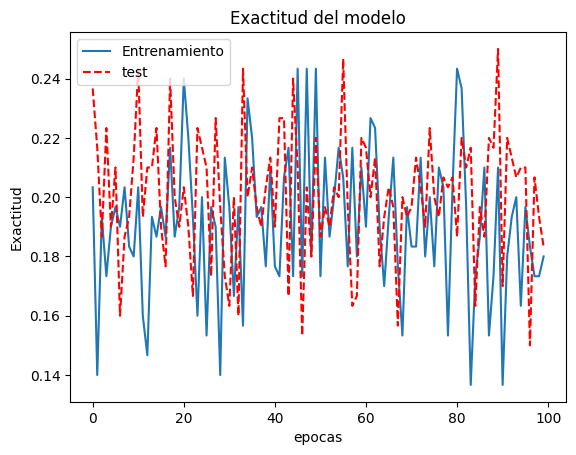

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],'r--')
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

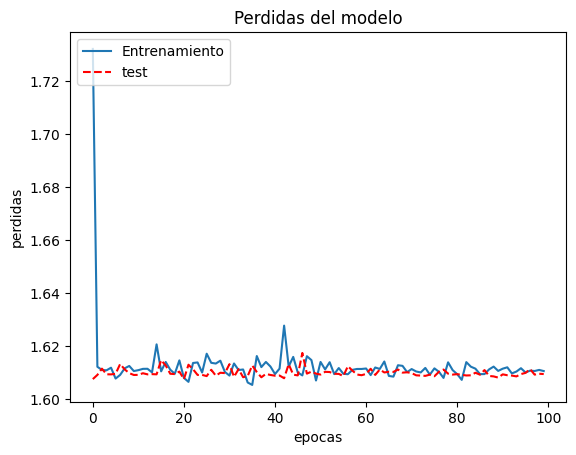

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'r--')
plt.title('Perdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

In [ ]:
#Guardamos el modelo
cnn.save('/content/drive/MyDrive/Entrenamiento/modeloVocales.h5')
cnn.save_weights('/content/drive/MyDrive/Entrenamiento/pesos.Vocales.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Entrenamiento/modeloVocales.h5')

# Ruta de la carpeta que contiene las imágenes de la base de datos
base_dir = '/content/drive/MyDrive/IC/Dedos/fotos/Entrenamiento'


In [ ]:
import random

In [ ]:
# Genera una lista con todas las letras del abecedario en lenguaje de señas
letras = ['letra_A', 'letra_U', 'letra_E', 'letra_I', 'letra_O']

# Elige una letra aleatoria de la lista
letra_aleatoria = random.choice(letras)


In [ ]:
# Genera una lista con algunos los numeros de las letras
letra_num = ['Dedos_0', 'Dedos_1', 'Dedos_2', 'Dedos_3', 'Dedos_4', 'Dedos_5', 'Dedos_6', 'Dedos_52', 'Dedos_129', 'Dedos_112', 'Dedos_99', 'Dedos_229', 'Dedos_3', 'Dedos_299', 'Dedos_7', 'Dedos_123', 'Dedos_66', 'Dedos_43', 'Dedos_44', 'Dedos_298']

# Elige una letra aleatoria de la lista
letra_num_al = random.choice(letra_num)

In [ ]:
ruta_imagen = f"{base_dir}/{letra_aleatoria}/{letra_num_al}.jpg"

In [ ]:
ruta_imagen

'/content/drive/MyDrive/IC/Dedos/fotos/Entrenamiento/letra_A/Dedos_0.jpg'

In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image

In [ ]:
# Carga la imagen y realiza el preprocesamiento necesario
imagen = Image.open(ruta_imagen)
imagen = imagen.resize((200, 200))  # Asegúrate de ajustar el tamaño de la imagen según tus necesidades
imagen = tf.keras.preprocessing.image.img_to_array(imagen)
imagen = imagen / 255.0  # Normaliza los valores de píxeles al rango [0, 1]
imagen = tf.expand_dims(imagen, axis=0)

In [ ]:
# Realiza la predicción utilizando el modelo
prediccion = model.predict(imagen)
etiqueta_predicha = letras[prediccion.argmax()]

1/1 [==============================] - 0s 58ms/step


In [ ]:
# Imprime el resultado
print("Letra predicha:", etiqueta_predicha)

Letra predicha: letra_U
